<a href="https://colab.research.google.com/github/alisonau/AGNewsNLP/blob/main/AGNewsNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyze AG_NEWS_SUBSET Data <br>

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.<br> 

For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html<br> 


The AG's news topic classification dataset is constructed by choosing 4 largest classes (**World**, **Sports**, **Business**, and **Sci/Tech**) from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.<br>

Homepage: https://arxiv.org/abs/1509.01626<br>

Source code: tfds.text.AGNewsSubset

Versions:

1.0.0 (default): No release notes.
Download size: 11.24 MiB

Dataset size: 35.79 MiB

## References
1. Deep Learning with Python, Francois Chollet (https://learning.oreilly.com/library/view/deep-learning-with/9781617296864/)
 * Chapter 10: Deep learning for time series
 * Chapter 11: Deep learning for text
2. Deep Learning A Visual Approach, Andrew Glassner (https://learning.oreilly.com/library/view/deep-learning/9781098129019/)
 * Chapter 19: Recurrent Neural Networks
 * Chapter 20: Attention and Transformers

## Processing words as a sequence: The sequence model approach

To implement a sequence model, you’d start by representing your input samples as sequences of integer indices (one integer standing for one word). Then, you’d map each integer to a vector to obtain vector sequences. Finally, you’d feed these sequences of vectors into a stack of layers that could cross-correlate features from adjacent vectors, such as a 1D convnet, a RNN, or a Transformer.

For some time around 2016–2017, bidirectional RNNs (in particular, `bidirectional LSTMs`) were considered to be the state of the art for sequence modeling. However, nowadays sequence modeling is almost universally done with `Transformers`. 

F. Chollet: "One-dimensional convnets were never very popular in NLP, even though, a residual stack of depthwise-separable 1D convolutions can often achieve comparable performance to a bidirectional LSTM, at a greatly reduced computational cost."

# Configuration

## Import Packages

In [ ]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import re
import string

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Verify TensorFlow version and Keras version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.2


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


## Visualization Utility Functions

In [ ]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)
  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

## Vectorization Class

In [ ]:
class Vectorizer:
    def standardize(self, text):
        text = text.lower()
        return "".join(char for char in text if char not in string.punctuation)

    def tokenize(self, text):
        text = self.standardize(text)
        return text.split()

    def make_vocabulary(self, dataset):
        self.vocabulary = {"": 0, "[UNK]": 1}
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        self.inverse_vocabulary = dict(
            (v, k) for k, v in self.vocabulary.items())

    def encode(self, text):
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token, 1) for token in tokens]

    def decode(self, int_sequence):
        return " ".join(
            self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)


## Load Data

In [ ]:
(ds_train, ds_test), ds_info = tfds.load('ag_news_subset', 
          split = (tfds.Split.TRAIN, tfds.Split.TEST),
          as_supervised=True,
          with_info=True
          )

print('info', ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ag_news_subset/1.0.0.incompleteGHERDW/ag_news_subset-train.tfrecord*...:   0%|…

Generating test examples...:   0%|          | 0/7600 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ag_news_subset/1.0.0.incompleteGHERDW/ag_news_subset-test.tfrecord*...:   0%| …

Dataset ag_news_subset downloaded and prepared to ~/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.
info tfds.core.DatasetInfo(
    name='ag_news_subset',
    full_name='ag_news_subset/1.0.0',
    description="""
    AG is a collection of more than 1 million news articles.
    News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
    ComeToMyHead is an academic news search engine which has been running since July, 2004.
    The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
    information retrieval (ranking, search, etc), xml, data compression, data streaming,
    and any other non-commercial activity.
    For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .
    
    The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from 

Note how the code above returns a dictionary. We want to operate some preprocessing, thus we are going to load data through the usual pandas dataframe from csv, and then convert to a tensorflow dataset, which is the robust, and ready-to-parallel computing format we want to use.

In [ ]:
%%bash
wget https://s3.amazonaws.com/fast-ai-nlp/ag_news_csv.tgz
mkdir -p data && tar -xvzf ag_news_csv.tgz -C data/

ag_news_csv/
ag_news_csv/train.csv
ag_news_csv/readme.txt
ag_news_csv/test.csv
ag_news_csv/classes.txt


--2022-08-06 19:05:20--  https://s3.amazonaws.com/fast-ai-nlp/ag_news_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.69.166
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.69.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11784419 (11M) [application/x-tar]
Saving to: ‘ag_news_csv.tgz’

     0K .......... .......... .......... .......... ..........  0%  801K 14s
    50K .......... .......... .......... .......... ..........  0%  801K 14s
   100K .......... .......... .......... .......... ..........  1%  802K 14s
   150K .......... .......... .......... .......... ..........  1%  129M 11s
   200K .......... .......... .......... .......... ..........  2%  124M 8s
   250K .......... .......... .......... .......... ..........  2%  812K 9s
   300K .......... .......... .......... .......... ..........  3% 91.3M 8s
   350K .......... .......... .......... .......... ..........  3%  118M 7s
   400K .......... .......... .......... ...

In [ ]:
train_df = pd.read_csv('/content/data/ag_news_csv/train.csv', engine='python', encoding='utf-8', header =None, names=['Class Index',	'Title',	'Description'])
test_df = pd.read_csv('/content/data/ag_news_csv/test.csv', engine='python', encoding='utf-8', header = None, names=['Class Index',	'Title',	'Description'])

# EDA

## Preview Training and Test Data

In [ ]:
print(f"There are {train_df.shape[0]} news articles for training.")
print(f"There are {test_df.shape[0]} news articles for testing.")

There are 120000 news articles for training.
There are 7600 news articles for testing.


In [ ]:
train_df.head(5)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
test_df.head(5)

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


## Counts by Class

In [ ]:
categories = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}
train_df['Class Index'].value_counts(sort=False).rename(index=categories)
# train evenly divided across classes 

Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: Class Index, dtype: int64

In [ ]:
categories = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}
test_df['Class Index'].value_counts(sort=False).rename(index=categories)
# test also evenly divided across classes 

Business    1900
Sci/Tech    1900
Sports      1900
World       1900
Name: Class Index, dtype: int64

## TextVectorization Layer & Standardize Text

In [ ]:
text_vectorization = TextVectorization(
    output_mode="int",
)
text_only_train_ds = ds_train.map(lambda x, y: x)

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.

In [ ]:
text_vectorization.adapt(text_only_train_ds) # standardize text with adapt method

## Number of Words in Training Corpus

In [ ]:
vocab = text_vectorization.get_vocabulary()
print(f"There are {len(vocab)} unique vocabulary words in the training set corpus.")

There are 93145 unique vocabulary words in the training set corpus.


In [ ]:
doc_sizes = []
corpus = []
for example, _ in ds_train:
  enc_example = text_vectorization(example)
  doc_sizes.append(enc_example.shape[0])
  corpus+=list(enc_example.numpy())

In [ ]:
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")
# tokens means words

There are 3677503 words in the corpus of 120000 news articles.
Each news article has between 3 and 173 tokens in it.


## Plot Distribution of Tokens Per Article

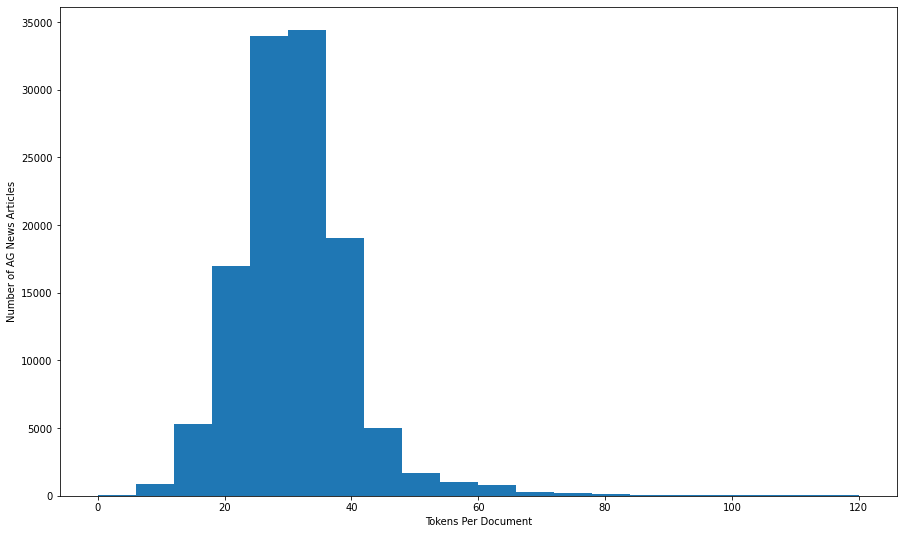

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");
# almost normal distribution. Probably wouldn't see this in real life

## Most Common Words

In [ ]:
# remove punctuations
def remove_punct(text):
    table=str.maketrans('','', string.punctuation)
    return text.translate(table)

train_df['Description'] = train_df['Description'].apply(lambda x : remove_punct(x))

In [ ]:
# create corpus of words (earlier corpus was of vectors/numeric representation)
corpus_words=[]
    
for x in train_df['Description'].str.split():
    for i in x:
        i = i.lower() # make lowercase
        corpus_words.append(i)

len(corpus_words)

3677503

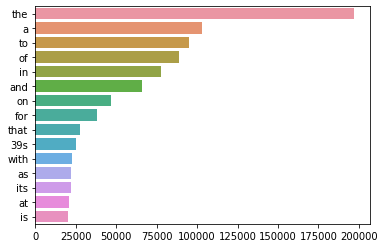

In [ ]:
# most common words 
counter=Counter(corpus_words)

most=counter.most_common()
x=[]
y=[]
for word, count in most[:15]:
      x.append(word)
      y.append(count)

sns.barplot(x=y, y=x);

In [ ]:
# list of stopwords
stop = set(stopwords.words('english'))

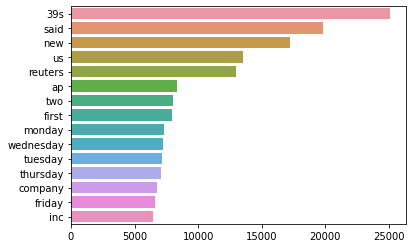

In [ ]:
# most common words excluding stop words
counter=Counter(corpus_words)

most=counter.most_common()
x=[]
y=[]
cnt=0
for word, count in most:
  if cnt < 15:
    if (word not in stop):
        x.append(word)
        y.append(count)
        cnt+=1

sns.barplot(x=y, y=x);

# Data Processing

## Convert TensorFlow Dataset

In [ ]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

dataset,info=\
tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test'],batch_size = 32
          , as_supervised=True)

train_ds, val_ds, test_ds = dataset
text_only_train_ds = train_ds.map(lambda x, y: x)

W0806 19:05:28.960477 140038290708352 download_and_prepare.py:43] ***`tfds build` should be used instead of `download_and_prepare`.***
INFO[build.py]: Loading dataset ag_news_subset from imports: tensorflow_datasets.text.ag_news_subset
INFO[dataset_info.py]: Load dataset info from ~/tensorflow_datasets/ag_news_subset/1.0.0
INFO[build.py]: download_and_prepare for dataset ag_news_subset/1.0.0...
INFO[dataset_builder.py]: Reusing dataset ag_news_subset (~/tensorflow_datasets/ag_news_subset/1.0.0)
INFO[build.py]: Dataset generation complete...

tfds.core.DatasetInfo(
    name='ag_news_subset',
    full_name='ag_news_subset/1.0.0',
    description="""
    AG is a collection of more than 1 million news articles.
    News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
    ComeToMyHead is an academic news search engine which has been running since July, 2004.
    The dataset is provided by the academic comunity for research purpo

## Extract Target Variables

In [ ]:
def get_labels(tfdataset, batched=False):
    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 
    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels

    return labels

In [ ]:
test_ds_labels = get_labels(test_ds)
len(test_ds_labels)

7600

## Display The Number of Batches

In [ ]:
len(train_ds), len(val_ds), len(test_ds)

(3563, 188, 238)

## Displaying The Shapes and Dtypes of the First Batch

In [ ]:
for inputs, targets in train_ds:
    print("No. of articles in first batch (inputs.shape):", inputs.shape)
    print()
    print("Articles are type (inputs.dtype):", inputs.dtype)
    print()
    print("No. of labels in first batch (targets.shape):", targets.shape)
    print()
    print("Labels are type (targets.dtype):", targets.dtype)
    print()
    print("First news article (inputs[0]):", inputs[0])
    print()
    print("Label of first article (targets[0]):", targets[0])
    break

No. of articles in first batch (inputs.shape): (32,)

Articles are type (inputs.dtype): <dtype: 'string'>

No. of labels in first batch (targets.shape): (32,)

Labels are type (targets.dtype): <dtype: 'int64'>

First news article (inputs[0]): tf.Tensor(b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.', shape=(), dtype=string)

Label of first article (targets[0]): tf.Tensor(3, shape=(), dtype=int64)


# Experiment 1 - 30 words/doc

## Prepare Integer Sequence Datasets

In [ ]:
max_length = 30 # words per article used (first 30 words)
max_tokens = 1000 # words in vocabulary (1000 most frequent words)
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

## Word Embedding with GloVe

There are various precomputed databases of word embeddings that you can download and use in a Keras Embedding layer. `Word2vec` is one of them. Another popular one is called `Global Vectors for Word Representatio`n (GloVe, https://nlp.stanford.edu/projects/glove), which was developed by Stanford researchers in 2014. This embedding technique is based on factorizing a matrix of word co-occurrence statistics. Its developers have made available precomputed embeddings for millions of English tokens, obtained from Wikipedia data and Common Crawl data.

First, let’s download the GloVe word embeddings precomputed on the 2014 English Wikipedia dataset. It’s an 822 MB zip file containing 100-dimensional embedding vectors for 400,000 words (or non-word tokens).

<div class="alert alert-block alert-success"><b>GloVe: Global Vectors for Word Representation</b><br>
https://nlp.stanford.edu/projects/glove/</div>

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-08-06 19:05:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-06 19:05:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-06 19:05:50--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# parse GloVe word-embeddings file
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ") # np.dtype('f') returns dtype('float32')
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


Next, let’s build an embedding matrix that you can load into an Embedding layer. It must be a matrix of shape `(max_words, embedding_dim)`, where each entry *i* contains the `embedding_dim`-dimensional vector for the word of index *i* in the reference word index (built during tokenization).

In [ ]:
# prepare GloVe word-embeddings matrix
embedding_dim = 100

# Retrieve the vocabulary indexed by our previous TextVectorization layer.
vocabulary = text_vectorization.get_vocabulary()

# Use it to create a mapping from words to their index in the vocabulary.
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Prepare a matrix that we’ll fill with the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Fill entry i in the matrix with the word vector for index i.
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:  # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

## Build & Compile Model

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded) # right to left and right to left. 32 cells
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy", # didn't one-hot encode the labels 
              metrics=["accuracy"])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_5 (Embedding)     (None, None, 100)         100000    
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 134,308
Trainable params: 34,308
Non-trainable params: 100,000
________________________________________________

## Train Model

In [ ]:
%%time
history = model.fit(int_train_ds, 
                    validation_data=int_val_ds, 
                    epochs=200, 
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint("model1.keras", save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) # if val accuracy doesn't improve after 3 epochs, stop training
                        ]
                    )

Epoch 1/200
3563/3563 [==============================] - 44s 10ms/step - loss: 0.5183 - accuracy: 0.8124 - val_loss: 0.4316 - val_accuracy: 0.8480
Epoch 2/200
3563/3563 [==============================] - 34s 10ms/step - loss: 0.4491 - accuracy: 0.8383 - val_loss: 0.4132 - val_accuracy: 0.8538
Epoch 3/200
3563/3563 [==============================] - 35s 10ms/step - loss: 0.4300 - accuracy: 0.8446 - val_loss: 0.4032 - val_accuracy: 0.8557
Epoch 4/200
3563/3563 [==============================] - 35s 10ms/step - loss: 0.4185 - accuracy: 0.8487 - val_loss: 0.3957 - val_accuracy: 0.8587
Epoch 5/200
3563/3563 [==============================] - 34s 10ms/step - loss: 0.4087 - accuracy: 0.8520 - val_loss: 0.3929 - val_accuracy: 0.8565
Epoch 6/200
3563/3563 [==============================] - 34s 10ms/step - loss: 0.4009 - accuracy: 0.8551 - val_loss: 0.3924 - val_accuracy: 0.8590
Epoch 7/200
3563/3563 [==============================] - 35s 10ms/step - loss: 0.3945 - accuracy: 0.8576 - val_loss: 0

## Test Model

In [ ]:
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 1s 4ms/step - loss: 0.4023 - accuracy: 0.8562
Test acc: 0.856


## Plot Performance Metrics

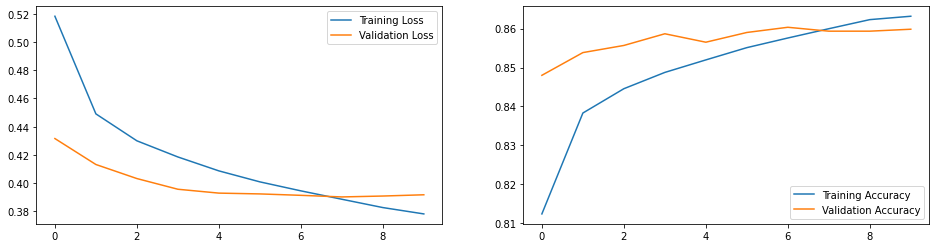

In [ ]:
plot_history(history)

## Confusion Matrix

In [ ]:
pred_test = model.predict(int_test_ds)
pred_test=np.argmax(pred_test, axis=1)

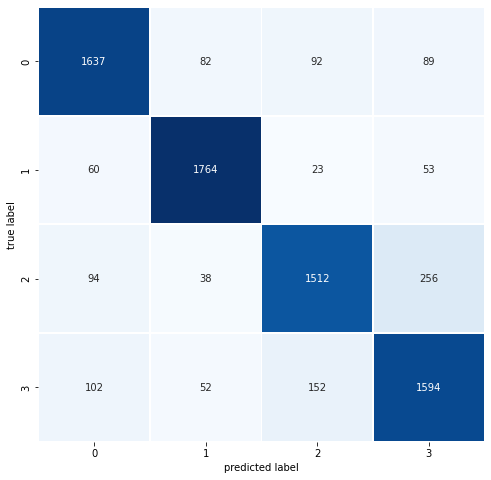

In [ ]:
plot_confusion_matrix(test_ds_labels, pred_test)

## Classification Report

In [ ]:
print_validation_report(test_ds_labels, pred_test)

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1900
           1       0.91      0.93      0.92      1900
           2       0.85      0.80      0.82      1900
           3       0.80      0.84      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600

Accuracy Score: 0.8561842105263158
Root Mean Square Error: 0.6780389679843358


# Experiment 2 - 40 words/doc

## Prepare Integer Sequence Datasets

In [ ]:
max_length = 40 # words per article used (first 40 words)
max_tokens = 1000 # words in vocabulary (1000 most frequent words)
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

## Word Embedding with GloVe

In [ ]:
# prepare GloVe word-embeddings matrix
embedding_dim = 100

# Retrieve the vocabulary indexed by our previous TextVectorization layer.
vocabulary = text_vectorization.get_vocabulary()

# Use it to create a mapping from words to their index in the vocabulary.
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Prepare a matrix that we’ll fill with the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Fill entry i in the matrix with the word vector for index i.
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:  # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

## Build & Compile Model

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded) # right to left and right to left. 32 cells
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy", # didn't one-hot encode the labels 
              metrics=["accuracy"])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         100000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 134,308
Trainable params: 34,308
Non-trainable params: 100,000
________________________________________________

## Train Model

In [ ]:
%%time
history = model.fit(int_train_ds, 
                    validation_data=int_val_ds, 
                    epochs=200, 
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint("model2.keras", save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) # if val accuracy doesn't improve after 3 epochs, stop training
                        ]
                    )

Epoch 1/200
3563/3563 [==============================] - 41s 11ms/step - loss: 0.4566 - accuracy: 0.8368 - val_loss: 0.4065 - val_accuracy: 0.8563
Epoch 2/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.4254 - accuracy: 0.8479 - val_loss: 0.3930 - val_accuracy: 0.8623
Epoch 3/200
3563/3563 [==============================] - 38s 11ms/step - loss: 0.4113 - accuracy: 0.8525 - val_loss: 0.3838 - val_accuracy: 0.8628
Epoch 4/200
3563/3563 [==============================] - 37s 10ms/step - loss: 0.3990 - accuracy: 0.8571 - val_loss: 0.3795 - val_accuracy: 0.8618
Epoch 5/200
3563/3563 [==============================] - 37s 10ms/step - loss: 0.3911 - accuracy: 0.8592 - val_loss: 0.3764 - val_accuracy: 0.8627
Epoch 6/200
3563/3563 [==============================] - 37s 10ms/step - loss: 0.3824 - accuracy: 0.8627 - val_loss: 0.3749 - val_accuracy: 0.8658
Epoch 7/200
3563/3563 [==============================] - 37s 10ms/step - loss: 0.3767 - accuracy: 0.8645 - val_loss: 0

## Test Model

In [ ]:
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 1s 4ms/step - loss: 0.3879 - accuracy: 0.8599
Test acc: 0.860


## Plot Performance Metrics

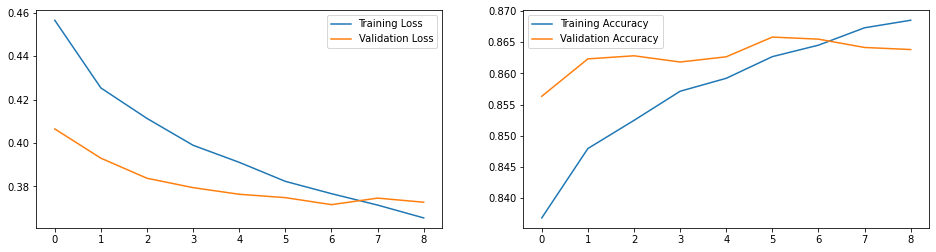

In [ ]:
plot_history(history)

## Confusion Matrix

In [ ]:
pred_test = model.predict(int_test_ds)
pred_test=np.argmax(pred_test, axis=1)

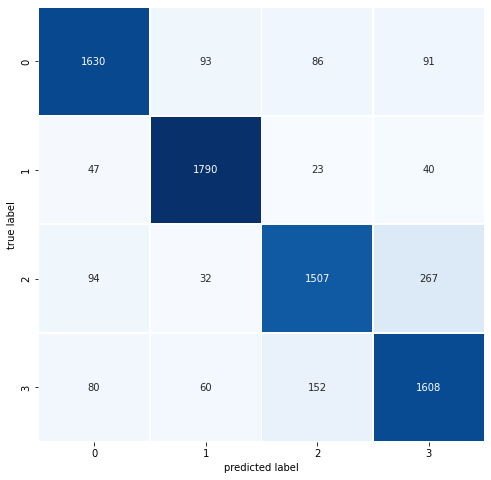

In [ ]:
plot_confusion_matrix(test_ds_labels, pred_test)

## Classification Report

In [ ]:
print_validation_report(test_ds_labels, pred_test)

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1900
           1       0.91      0.94      0.92      1900
           2       0.85      0.79      0.82      1900
           3       0.80      0.85      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600

Accuracy Score: 0.8598684210526316
Root Mean Square Error: 0.6562453007350545


# Experiment 3 - 60 words/doc

## Prepare Integer Sequence Datasets

In [ ]:
max_length = 60 # words per article used
max_tokens = 1000 # words in vocabulary
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

## Word Embedding with GloVe

In [ ]:
# prepare GloVe word-embeddings matrix
embedding_dim = 100

# Retrieve the vocabulary indexed by our previous TextVectorization layer.
vocabulary = text_vectorization.get_vocabulary()

# Use it to create a mapping from words to their index in the vocabulary.
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Prepare a matrix that we’ll fill with the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Fill entry i in the matrix with the word vector for index i.
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:  # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

## Build & Compile Model

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded) # right to left and right to left. 32 cells
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy", # didn't one-hot encode the labels 
              metrics=["accuracy"])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 100)         100000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 4)                 260       
                                                                 
Total params: 134,308
Trainable params: 34,308
Non-trainable params: 100,000
________________________________________________

## Train Model

In [ ]:
%%time
history = model.fit(int_train_ds, 
                    validation_data=int_val_ds, 
                    epochs=200, 
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint("model3.keras", save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) # if val accuracy doesn't improve after 3 epochs, stop training
                        ]
                    )

Epoch 1/200
3563/3563 [==============================] - 51s 12ms/step - loss: 0.5072 - accuracy: 0.8172 - val_loss: 0.4157 - val_accuracy: 0.8513
Epoch 2/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.4307 - accuracy: 0.8460 - val_loss: 0.3940 - val_accuracy: 0.8575
Epoch 3/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.4131 - accuracy: 0.8522 - val_loss: 0.3836 - val_accuracy: 0.8627
Epoch 4/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.3995 - accuracy: 0.8575 - val_loss: 0.3776 - val_accuracy: 0.8693
Epoch 5/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.3893 - accuracy: 0.8612 - val_loss: 0.3734 - val_accuracy: 0.8695
Epoch 6/200
3563/3563 [==============================] - 43s 12ms/step - loss: 0.3819 - accuracy: 0.8641 - val_loss: 0.3762 - val_accuracy: 0.8703
Epoch 7/200
3563/3563 [==============================] - 41s 12ms/step - loss: 0.3754 - accuracy: 0.8660 - val_loss: 0

## Test Model

In [ ]:
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 1s 5ms/step - loss: 0.3900 - accuracy: 0.8620
Test acc: 0.862


## Plot Performance Metrics

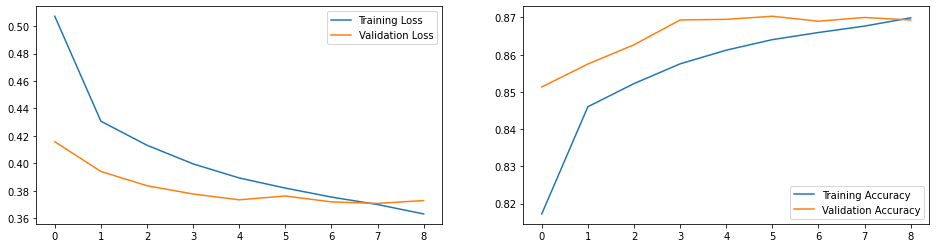

In [ ]:
plot_history(history)

## Confusion Matrix

In [ ]:
pred_test = model.predict(int_test_ds)
pred_test=np.argmax(pred_test, axis=1)

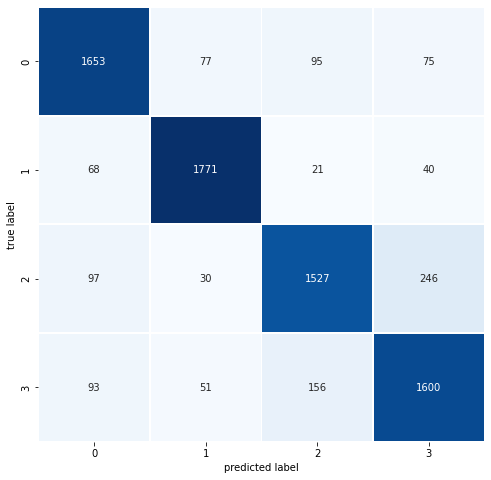

In [ ]:
plot_confusion_matrix(test_ds_labels, pred_test)

## Classification Report

In [ ]:
print_validation_report(test_ds_labels, pred_test)

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1900
           1       0.92      0.93      0.93      1900
           2       0.85      0.80      0.83      1900
           3       0.82      0.84      0.83      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600

Accuracy Score: 0.8619736842105263
Root Mean Square Error: 0.6531301151902438


# Experiment 4 - 2,000 vocab words

## Prepare Integer Sequence Datasets

In [ ]:
max_length = 60 # words per article used
max_tokens = 2000 # words in vocabulary
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

## Word Embedding with GloVe

In [ ]:
# prepare GloVe word-embeddings matrix
embedding_dim = 100

# Retrieve the vocabulary indexed by our previous TextVectorization layer.
vocabulary = text_vectorization.get_vocabulary()

# Use it to create a mapping from words to their index in the vocabulary.
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Prepare a matrix that we’ll fill with the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Fill entry i in the matrix with the word vector for index i.
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:  # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

## Build & Compile Model

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded) # right to left and right to left. 32 cells
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy", # didn't one-hot encode the labels 
              metrics=["accuracy"])
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_7 (Embedding)     (None, None, 100)         200000    
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                                 
Total params: 234,308
Trainable params: 34,308
Non-trainable params: 200,000
________________________________________________

## Train Model

In [ ]:
%%time
history = model.fit(int_train_ds, 
                    validation_data=int_val_ds, 
                    epochs=200, 
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint("model4.keras", save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) # if val accuracy doesn't improve after 3 epochs, stop training
                        ]
                    )

Epoch 1/200
3563/3563 [==============================] - 50s 12ms/step - loss: 0.4431 - accuracy: 0.8433 - val_loss: 0.3704 - val_accuracy: 0.8712
Epoch 2/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.3700 - accuracy: 0.8699 - val_loss: 0.3392 - val_accuracy: 0.8812
Epoch 3/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.3510 - accuracy: 0.8765 - val_loss: 0.3377 - val_accuracy: 0.8825
Epoch 4/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.3383 - accuracy: 0.8812 - val_loss: 0.3282 - val_accuracy: 0.8852
Epoch 5/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.3296 - accuracy: 0.8836 - val_loss: 0.3260 - val_accuracy: 0.8868
Epoch 6/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.3223 - accuracy: 0.8869 - val_loss: 0.3258 - val_accuracy: 0.8882
Epoch 7/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.3148 - accuracy: 0.8896 - val_loss: 0

## Test Model

In [ ]:
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 1s 5ms/step - loss: 0.3388 - accuracy: 0.8841
Test acc: 0.884


## Plot Performance Metrics

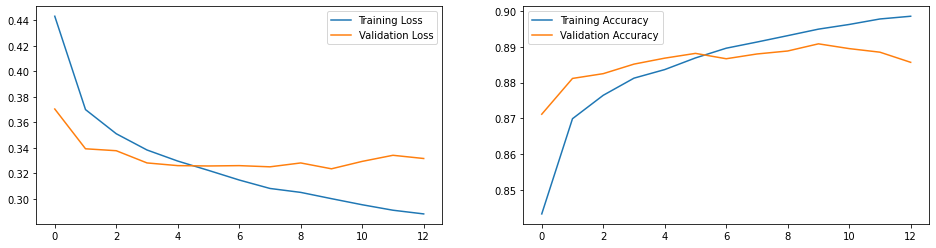

In [ ]:
plot_history(history)

## Confusion Matrix

In [ ]:
pred_test = model.predict(int_test_ds)
pred_test=np.argmax(pred_test, axis=1)

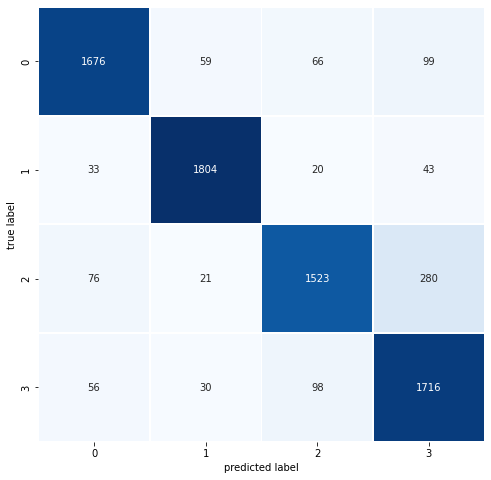

In [ ]:
plot_confusion_matrix(test_ds_labels, pred_test)

## Classification Report

In [ ]:
print_validation_report(test_ds_labels, pred_test)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1900
           1       0.94      0.95      0.95      1900
           2       0.89      0.80      0.84      1900
           3       0.80      0.90      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.89      0.88      0.88      7600
weighted avg       0.89      0.88      0.88      7600

Accuracy Score: 0.8840789473684211
Root Mean Square Error: 0.6032805055867897


# Experiment 5 - 3,000 vocab words

## Prepare Integer Sequence Datasets

In [ ]:
max_length = 60 # words per article used
max_tokens = 3000 # words in vocabulary
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

## Word Embedding with GloVe

In [ ]:
# prepare GloVe word-embeddings matrix
embedding_dim = 100

# Retrieve the vocabulary indexed by our previous TextVectorization layer.
vocabulary = text_vectorization.get_vocabulary()

# Use it to create a mapping from words to their index in the vocabulary.
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Prepare a matrix that we’ll fill with the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Fill entry i in the matrix with the word vector for index i.
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:  # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

## Build & Compile Model

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded) # right to left and right to left. 32 cells
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy", # didn't one-hot encode the labels 
              metrics=["accuracy"])
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_8 (Embedding)     (None, None, 100)         300000    
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 4)                 260       
                                                                 
Total params: 334,308
Trainable params: 34,308
Non-trainable params: 300,000
________________________________________________

## Train Model

In [ ]:
%%time
history = model.fit(int_train_ds, 
                    validation_data=int_val_ds, 
                    epochs=200, 
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint("model5.keras", save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) # if val accuracy doesn't improve after 3 epochs, stop training
                        ]
                    )

Epoch 1/200
3563/3563 [==============================] - 51s 12ms/step - loss: 0.4168 - accuracy: 0.8554 - val_loss: 0.3384 - val_accuracy: 0.8815
Epoch 2/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.3477 - accuracy: 0.8795 - val_loss: 0.3195 - val_accuracy: 0.8888
Epoch 3/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.3277 - accuracy: 0.8857 - val_loss: 0.3127 - val_accuracy: 0.8898
Epoch 4/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.3163 - accuracy: 0.8892 - val_loss: 0.3075 - val_accuracy: 0.8958
Epoch 5/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.3059 - accuracy: 0.8926 - val_loss: 0.3047 - val_accuracy: 0.8963
Epoch 6/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.2977 - accuracy: 0.8956 - val_loss: 0.3052 - val_accuracy: 0.8967
Epoch 7/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.2914 - accuracy: 0.8978 - val_loss: 0

## Test Model

In [ ]:
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 1s 5ms/step - loss: 0.3244 - accuracy: 0.8901
Test acc: 0.890


## Plot Performance Metrics

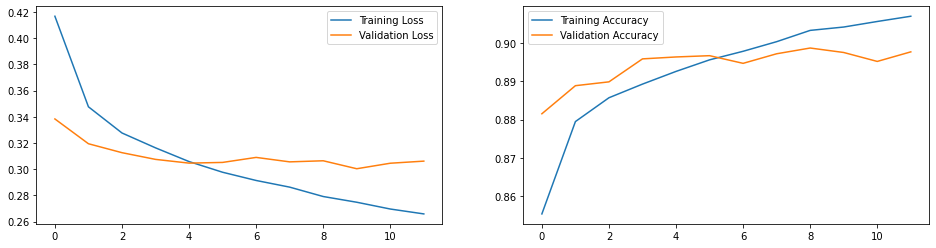

In [ ]:
plot_history(history)

## Confusion Matrix

In [ ]:
pred_test = model.predict(int_test_ds)
pred_test=np.argmax(pred_test, axis=1)

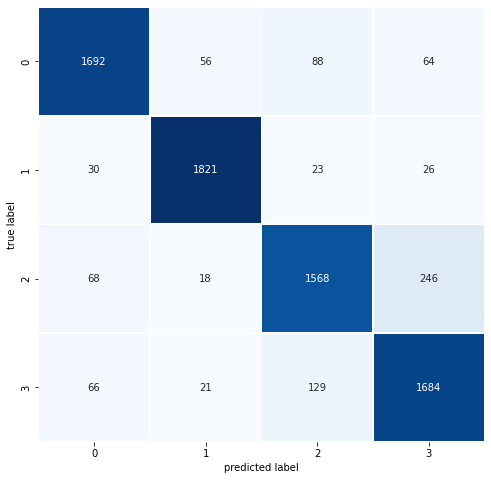

In [ ]:
plot_confusion_matrix(test_ds_labels, pred_test)

## Classification Report

In [ ]:
print_validation_report(test_ds_labels, pred_test)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1900
           1       0.95      0.96      0.95      1900
           2       0.87      0.83      0.85      1900
           3       0.83      0.89      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Accuracy Score: 0.8901315789473684
Root Mean Square Error: 0.5717010628494212


# Experiment 6 - 4,000 vocab words

## Prepare Integer Sequence Datasets

In [ ]:
max_length = 60 # words per article used
max_tokens = 4000 # words in vocabulary
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

## Word Embedding with GloVe

In [ ]:
# parse GloVe word-embeddings file
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ") # np.dtype('f') returns dtype('float32')
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [ ]:
# prepare GloVe word-embeddings matrix
embedding_dim = 100

# Retrieve the vocabulary indexed by our previous TextVectorization layer.
vocabulary = text_vectorization.get_vocabulary()

# Use it to create a mapping from words to their index in the vocabulary.
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Prepare a matrix that we’ll fill with the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Fill entry i in the matrix with the word vector for index i.
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:  # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

## Build & Compile Model

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded) # right to left and right to left. 32 cells
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy", # didn't one-hot encode the labels 
              metrics=["accuracy"])
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_10 (Embedding)    (None, None, 100)         400000    
                                                                 
 bidirectional_10 (Bidirecti  (None, 64)               34048     
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 4)                 260       
                                                                 
Total params: 434,308
Trainable params: 34,308
Non-trainable params: 400,000
_______________________________________________

## Train Model

In [ ]:
%%time
history = model.fit(int_train_ds, 
                    validation_data=int_val_ds, 
                    epochs=200, 
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint("model6.keras", save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) # if val accuracy doesn't improve after 3 epochs, stop training
                        ]
                    )

Epoch 1/200
3563/3563 [==============================] - 51s 12ms/step - loss: 0.4050 - accuracy: 0.8596 - val_loss: 0.3365 - val_accuracy: 0.8857
Epoch 2/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.3338 - accuracy: 0.8847 - val_loss: 0.3104 - val_accuracy: 0.8928
Epoch 3/200
3563/3563 [==============================] - 42s 12ms/step - loss: 0.3146 - accuracy: 0.8916 - val_loss: 0.3044 - val_accuracy: 0.8948
Epoch 4/200
3563/3563 [==============================] - 41s 11ms/step - loss: 0.3033 - accuracy: 0.8958 - val_loss: 0.3003 - val_accuracy: 0.8973
Epoch 5/200
3563/3563 [==============================] - 41s 11ms/step - loss: 0.2947 - accuracy: 0.8992 - val_loss: 0.2973 - val_accuracy: 0.8977
Epoch 6/200
3563/3563 [==============================] - 41s 11ms/step - loss: 0.2859 - accuracy: 0.9019 - val_loss: 0.2893 - val_accuracy: 0.8983
Epoch 7/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.2780 - accuracy: 0.9050 - val_loss: 0

## Test Model

In [ ]:
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 1s 5ms/step - loss: 0.3201 - accuracy: 0.8934
Test acc: 0.893


## Plot Performance Metrics

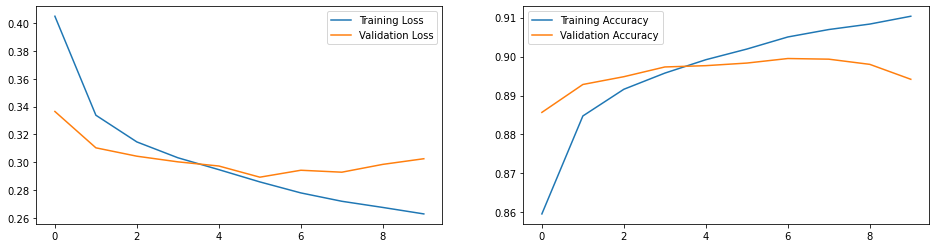

In [ ]:
plot_history(history)

## Confusion Matrix

In [ ]:
pred_test = model.predict(int_test_ds)
pred_test=np.argmax(pred_test, axis=1)

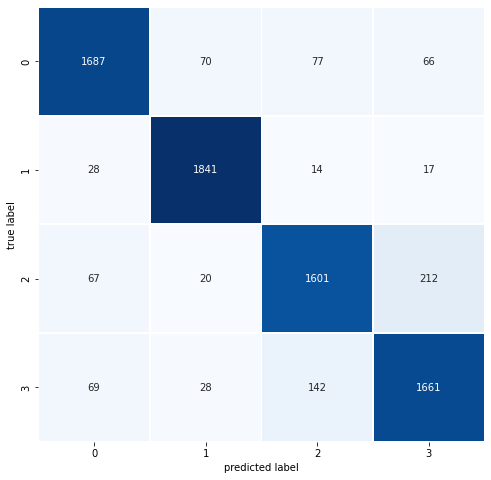

In [ ]:
plot_confusion_matrix(test_ds_labels, pred_test)

## Classification Report

In [ ]:
print_validation_report(test_ds_labels, pred_test)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1900
           1       0.94      0.97      0.95      1900
           2       0.87      0.84      0.86      1900
           3       0.85      0.87      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Accuracy Score: 0.8934210526315789
Root Mean Square Error: 0.5685855025272897


# Experiment 7 - GloVe 200d

## Prepare Integer Sequence Datasets

In [ ]:
max_length = 60 # words per article used
max_tokens = 4000 # words in vocabulary
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

## Word Embedding with GloVe

In [ ]:
# parse GloVe word-embeddings file
path_to_glove_file = "glove.6B.200d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ") # np.dtype('f') returns dtype('float32')
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


Next, let’s build an embedding matrix that you can load into an Embedding layer. It must be a matrix of shape `(max_words, embedding_dim)`, where each entry *i* contains the `embedding_dim`-dimensional vector for the word of index *i* in the reference word index (built during tokenization).

In [ ]:
# prepare GloVe word-embeddings matrix
embedding_dim = 200

# Retrieve the vocabulary indexed by our previous TextVectorization layer.
vocabulary = text_vectorization.get_vocabulary()

# Use it to create a mapping from words to their index in the vocabulary.
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Prepare a matrix that we’ll fill with the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Fill entry i in the matrix with the word vector for index i.
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:  # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

## Build & Compile Model

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded) # right to left and right to left. 32 cells
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy", # didn't one-hot encode the labels 
              metrics=["accuracy"])
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_11 (Embedding)    (None, None, 200)         800000    
                                                                 
 bidirectional_11 (Bidirecti  (None, 64)               59648     
 onal)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 4)                 260       
                                                                 
Total params: 859,908
Trainable params: 59,908
Non-trainable params: 800,000
_______________________________________________

## Train Model

In [ ]:
%%time
history = model.fit(int_train_ds, 
                    validation_data=int_val_ds, 
                    epochs=200, 
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint("model7.keras", save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) # if val accuracy doesn't improve after 3 epochs, stop training
                        ]
                    )

Epoch 1/200
3563/3563 [==============================] - 50s 12ms/step - loss: 0.3828 - accuracy: 0.8686 - val_loss: 0.3171 - val_accuracy: 0.8938
Epoch 2/200
3563/3563 [==============================] - 41s 12ms/step - loss: 0.3189 - accuracy: 0.8905 - val_loss: 0.3070 - val_accuracy: 0.8955
Epoch 3/200
3563/3563 [==============================] - 42s 12ms/step - loss: 0.2983 - accuracy: 0.8968 - val_loss: 0.2971 - val_accuracy: 0.9002
Epoch 4/200
3563/3563 [==============================] - 41s 11ms/step - loss: 0.2849 - accuracy: 0.9024 - val_loss: 0.2967 - val_accuracy: 0.9000
Epoch 5/200
3563/3563 [==============================] - 41s 11ms/step - loss: 0.2733 - accuracy: 0.9060 - val_loss: 0.2952 - val_accuracy: 0.8987
Epoch 6/200
3563/3563 [==============================] - 41s 11ms/step - loss: 0.2634 - accuracy: 0.9093 - val_loss: 0.2993 - val_accuracy: 0.9015
Epoch 7/200
3563/3563 [==============================] - 40s 11ms/step - loss: 0.2536 - accuracy: 0.9124 - val_loss: 0

## Test Model

In [ ]:
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 1s 5ms/step - loss: 0.3274 - accuracy: 0.8964
Test acc: 0.896


## Plot Performance Metrics

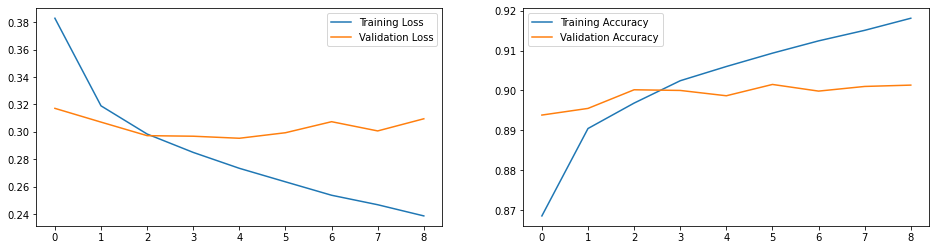

In [ ]:
plot_history(history)

## Confusion Matrix

In [ ]:
pred_test = model.predict(int_test_ds)
pred_test=np.argmax(pred_test, axis=1)

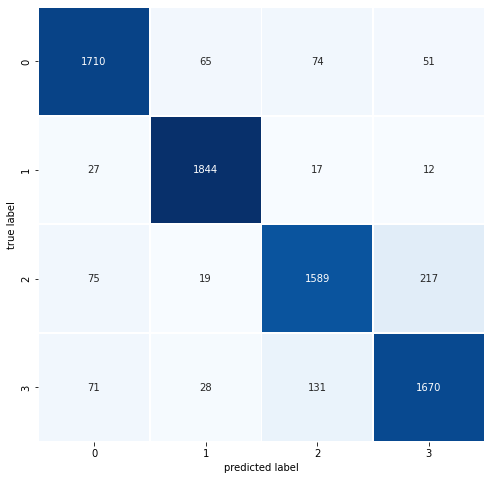

In [ ]:
plot_confusion_matrix(test_ds_labels, pred_test)

## Classification Report

In [ ]:
print_validation_report(test_ds_labels, pred_test)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1900
           1       0.94      0.97      0.96      1900
           2       0.88      0.84      0.86      1900
           3       0.86      0.88      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600

Accuracy Score: 0.8964473684210527
Root Mean Square Error: 0.5536957173108901


# Experiment 8 - 64 neurons

## Prepare Integer Sequence Datasets

In [ ]:
max_length = 60 # words per article used
max_tokens = 4000 # words in vocabulary
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

## Word Embedding with GloVe

In [ ]:
# parse GloVe word-embeddings file
path_to_glove_file = "glove.6B.200d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ") # np.dtype('f') returns dtype('float32')
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


Next, let’s build an embedding matrix that you can load into an Embedding layer. It must be a matrix of shape `(max_words, embedding_dim)`, where each entry *i* contains the `embedding_dim`-dimensional vector for the word of index *i* in the reference word index (built during tokenization).

In [ ]:
# prepare GloVe word-embeddings matrix
embedding_dim = 200

# Retrieve the vocabulary indexed by our previous TextVectorization layer.
vocabulary = text_vectorization.get_vocabulary()

# Use it to create a mapping from words to their index in the vocabulary.
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Prepare a matrix that we’ll fill with the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Fill entry i in the matrix with the word vector for index i.
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:  # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

## Build & Compile Model

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(64))(embedded) 
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 200)         800000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              135680    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 936,196
Trainable params: 136,196
Non-trainable params: 800,000
_________________________________________________

## Train Model

In [ ]:
%%time
history = model.fit(int_train_ds, 
                    validation_data=int_val_ds, 
                    epochs=200, 
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint("model8.keras", save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) # if val accuracy doesn't improve after 3 epochs, stop training
                        ]
                    )

Epoch 1/200
3563/3563 [==============================] - 76s 18ms/step - loss: 0.3659 - accuracy: 0.8723 - val_loss: 0.3148 - val_accuracy: 0.8875
Epoch 2/200
3563/3563 [==============================] - 57s 16ms/step - loss: 0.3059 - accuracy: 0.8939 - val_loss: 0.2970 - val_accuracy: 0.8940
Epoch 3/200
3563/3563 [==============================] - 57s 16ms/step - loss: 0.2817 - accuracy: 0.9022 - val_loss: 0.2946 - val_accuracy: 0.9002
Epoch 4/200
3563/3563 [==============================] - 56s 16ms/step - loss: 0.2628 - accuracy: 0.9085 - val_loss: 0.3036 - val_accuracy: 0.8993
Epoch 5/200
3563/3563 [==============================] - 56s 16ms/step - loss: 0.2488 - accuracy: 0.9145 - val_loss: 0.2912 - val_accuracy: 0.9017
Epoch 6/200
3563/3563 [==============================] - 56s 16ms/step - loss: 0.2341 - accuracy: 0.9188 - val_loss: 0.2995 - val_accuracy: 0.9005
Epoch 7/200
3563/3563 [==============================] - 55s 16ms/step - loss: 0.2193 - accuracy: 0.9240 - val_loss: 0

## Test Model

In [ ]:
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 2s 6ms/step - loss: 0.3318 - accuracy: 0.8987
Test acc: 0.899


## Plot Performance Metrics

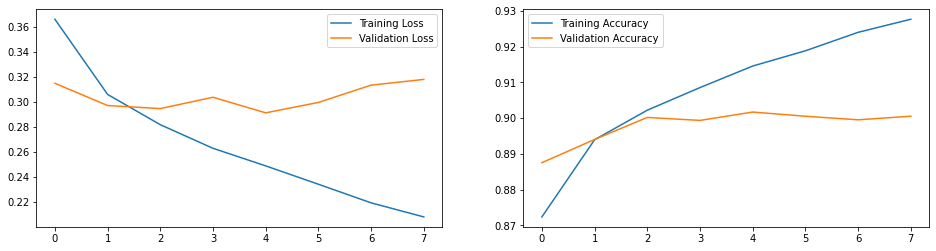

In [ ]:
plot_history(history)

## Confusion Matrix

In [ ]:
pred_test = model.predict(int_test_ds)
pred_test=np.argmax(pred_test, axis=1)

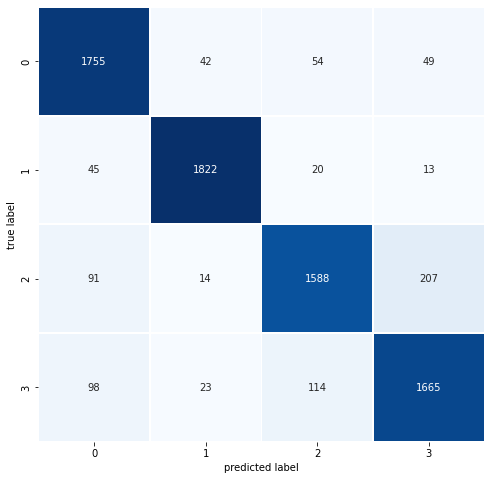

In [ ]:
plot_confusion_matrix(test_ds_labels, pred_test)

## Classification Report

In [ ]:
print_validation_report(test_ds_labels, pred_test)

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1900
           1       0.96      0.96      0.96      1900
           2       0.89      0.84      0.86      1900
           3       0.86      0.88      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600

Accuracy Score: 0.8986842105263158
Root Mean Square Error: 0.5722761571129799


# Experiment 9 - 128 neurons

## Prepare Integer Sequence Datasets

In [ ]:
max_length = 60 # words per article used
max_tokens = 4000 # words in vocabulary
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

## Word Embedding with GloVe

In [ ]:
# prepare GloVe word-embeddings matrix
embedding_dim = 200

# Retrieve the vocabulary indexed by our previous TextVectorization layer.
vocabulary = text_vectorization.get_vocabulary()

# Use it to create a mapping from words to their index in the vocabulary.
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Prepare a matrix that we’ll fill with the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Fill entry i in the matrix with the word vector for index i.
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:  # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

## Build & Compile Model

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(128))(embedded) 
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 200)         800000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              336896    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 1,137,924
Trainable params: 337,924
Non-trainable params: 800,000
_____________________________________________

## Train Model

In [ ]:
%%time
history = model.fit(int_train_ds, 
                    validation_data=int_val_ds, 
                    epochs=200, 
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint("model9.keras", save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) # if val accuracy doesn't improve after 3 epochs, stop training
                        ]
                    )

Epoch 1/200
3563/3563 [==============================] - 69s 17ms/step - loss: 0.3592 - accuracy: 0.8740 - val_loss: 0.3068 - val_accuracy: 0.8918
Epoch 2/200
3563/3563 [==============================] - 57s 16ms/step - loss: 0.2979 - accuracy: 0.8962 - val_loss: 0.2947 - val_accuracy: 0.8977
Epoch 3/200
3563/3563 [==============================] - 56s 16ms/step - loss: 0.2706 - accuracy: 0.9059 - val_loss: 0.2849 - val_accuracy: 0.9038
Epoch 4/200
3563/3563 [==============================] - 55s 16ms/step - loss: 0.2486 - accuracy: 0.9138 - val_loss: 0.2949 - val_accuracy: 0.9022
Epoch 5/200
3563/3563 [==============================] - 55s 15ms/step - loss: 0.2278 - accuracy: 0.9215 - val_loss: 0.2978 - val_accuracy: 0.9017
Epoch 6/200
3563/3563 [==============================] - 55s 15ms/step - loss: 0.2056 - accuracy: 0.9290 - val_loss: 0.3171 - val_accuracy: 0.9062
Epoch 7/200
3563/3563 [==============================] - 55s 15ms/step - loss: 0.1870 - accuracy: 0.9354 - val_loss: 0

## Test Model

In [ ]:
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 2s 6ms/step - loss: 0.3977 - accuracy: 0.9003
Test acc: 0.900


## Plot Performance Metrics

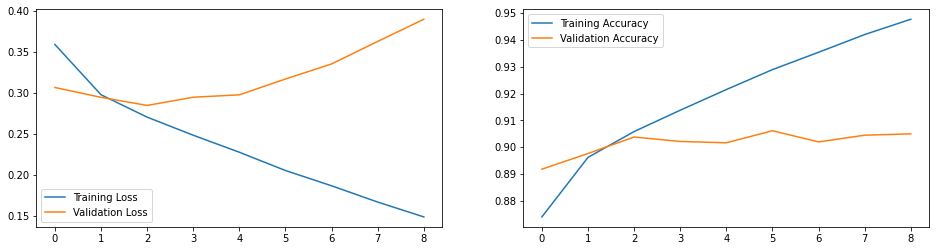

In [ ]:
plot_history(history)

## Confusion Matrix

In [ ]:
pred_test = model.predict(int_test_ds)
pred_test=np.argmax(pred_test, axis=1)

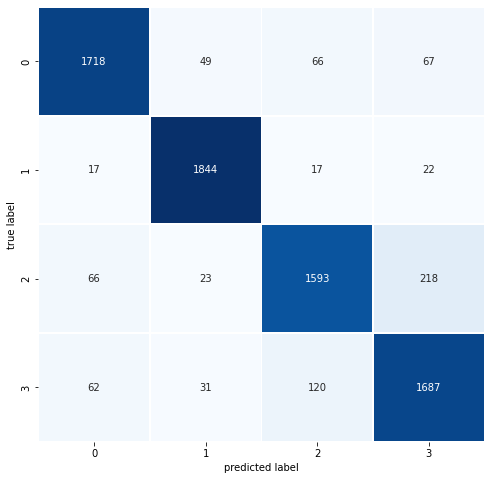

In [ ]:
plot_confusion_matrix(test_ds_labels, pred_test)

## Classification Report

In [ ]:
print_validation_report(test_ds_labels, pred_test)

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1900
           1       0.95      0.97      0.96      1900
           2       0.89      0.84      0.86      1900
           3       0.85      0.89      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600

Accuracy Score: 0.9002631578947369
Root Mean Square Error: 0.5554751403788898


# Experiment 10 - 2 layers (128, 64 nodes)

## Prepare Integer Sequence Datasets

In [ ]:
max_length = 60 # words per article used
max_tokens = 4000 # words in vocabulary
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

## Word Embedding with GloVe

In [ ]:
# prepare GloVe word-embeddings matrix
embedding_dim = 200

# Retrieve the vocabulary indexed by our previous TextVectorization layer.
vocabulary = text_vectorization.get_vocabulary()

# Use it to create a mapping from words to their index in the vocabulary.
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Prepare a matrix that we’ll fill with the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Fill entry i in the matrix with the word vector for index i.
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:  # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

## Build & Compile Model

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(embedded) 
x = layers.Bidirectional(layers.LSTM(64))(x) 
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_8 (Embedding)     (None, None, 200)         800000    
                                                                 
 bidirectional_22 (Bidirecti  (None, None, 256)        336896    
 onal)                                                           
                                                                 
 bidirectional_23 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 4)                 516

## Train Model

In [ ]:
%%time
history = model.fit(int_train_ds, 
                    validation_data=int_val_ds, 
                    epochs=200, 
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint("model10.keras", save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) # if val accuracy doesn't improve after 3 epochs, stop training
                        ]
                    )

Epoch 1/200
3563/3563 [==============================] - 129s 31ms/step - loss: 0.3599 - accuracy: 0.8747 - val_loss: 0.3121 - val_accuracy: 0.8915
Epoch 2/200
3563/3563 [==============================] - 102s 29ms/step - loss: 0.2948 - accuracy: 0.8978 - val_loss: 0.2923 - val_accuracy: 0.9007
Epoch 3/200
3563/3563 [==============================] - 101s 28ms/step - loss: 0.2655 - accuracy: 0.9083 - val_loss: 0.2962 - val_accuracy: 0.9053
Epoch 4/200
3563/3563 [==============================] - 100s 28ms/step - loss: 0.2395 - accuracy: 0.9166 - val_loss: 0.2949 - val_accuracy: 0.9063
Epoch 5/200
3563/3563 [==============================] - 101s 28ms/step - loss: 0.2160 - accuracy: 0.9252 - val_loss: 0.3057 - val_accuracy: 0.9003
Epoch 6/200
3563/3563 [==============================] - 100s 28ms/step - loss: 0.1946 - accuracy: 0.9329 - val_loss: 0.3494 - val_accuracy: 0.8997
Epoch 7/200
3563/3563 [==============================] - 100s 28ms/step - loss: 0.1728 - accuracy: 0.9402 - val_

## Test Model

In [ ]:
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 2s 10ms/step - loss: 0.3959 - accuracy: 0.8975
Test acc: 0.897


## Plot Performance Metrics

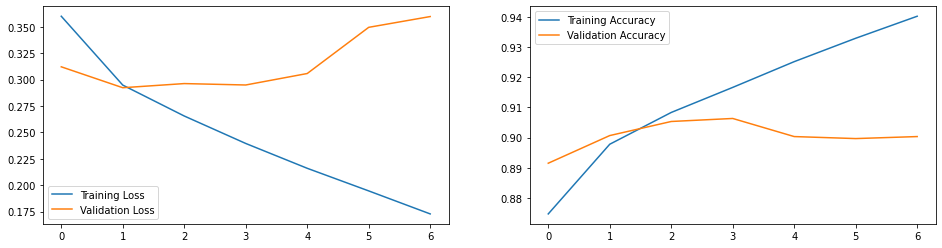

In [ ]:
plot_history(history)

## Confusion Matrix

In [ ]:
pred_test = model.predict(int_test_ds)
pred_test=np.argmax(pred_test, axis=1)

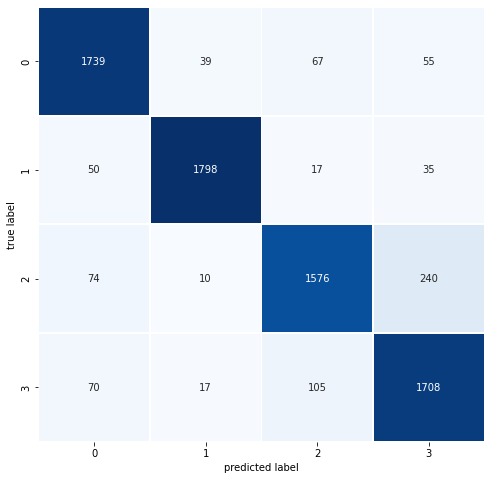

In [ ]:
plot_confusion_matrix(test_ds_labels, pred_test)

## Classification Report

In [ ]:
print_validation_report(test_ds_labels, pred_test)

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1900
           1       0.96      0.95      0.96      1900
           2       0.89      0.83      0.86      1900
           3       0.84      0.90      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600

Accuracy Score: 0.8975
Root Mean Square Error: 0.5570127089167148


# Experiment 11 - 2 layers (64, 32 nodes)

## Prepare Integer Sequence Datasets

In [ ]:
max_length = 60 # words per article used
max_tokens = 4000 # words in vocabulary
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

## Word Embedding with GloVe

In [ ]:
# prepare GloVe word-embeddings matrix
embedding_dim = 200

# Retrieve the vocabulary indexed by our previous TextVectorization layer.
vocabulary = text_vectorization.get_vocabulary()

# Use it to create a mapping from words to their index in the vocabulary.
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Prepare a matrix that we’ll fill with the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Fill entry i in the matrix with the word vector for index i.
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:  # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

## Build & Compile Model

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(embedded) 
x = layers.Bidirectional(layers.LSTM(32))(x) 
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_9 (Embedding)     (None, None, 200)         800000    
                                                                 
 bidirectional_24 (Bidirecti  (None, None, 128)        135680    
 onal)                                                           
                                                                 
 bidirectional_25 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 4)                 260

## Train Model

In [ ]:
%%time
history = model.fit(int_train_ds, 
                    validation_data=int_val_ds, 
                    epochs=200, 
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint("model11.keras", save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) # if val accuracy doesn't improve after 3 epochs, stop training
                        ]
                    )

Epoch 1/200
3563/3563 [==============================] - 127s 30ms/step - loss: 0.3740 - accuracy: 0.8710 - val_loss: 0.3136 - val_accuracy: 0.8920
Epoch 2/200
3563/3563 [==============================] - 101s 28ms/step - loss: 0.3042 - accuracy: 0.8951 - val_loss: 0.3015 - val_accuracy: 0.8942
Epoch 3/200
3563/3563 [==============================] - 101s 28ms/step - loss: 0.2765 - accuracy: 0.9048 - val_loss: 0.3010 - val_accuracy: 0.8982
Epoch 4/200
3563/3563 [==============================] - 101s 28ms/step - loss: 0.2545 - accuracy: 0.9125 - val_loss: 0.2971 - val_accuracy: 0.9015
Epoch 5/200
3563/3563 [==============================] - 99s 28ms/step - loss: 0.2359 - accuracy: 0.9201 - val_loss: 0.3129 - val_accuracy: 0.9005
Epoch 6/200
3563/3563 [==============================] - 98s 28ms/step - loss: 0.2181 - accuracy: 0.9259 - val_loss: 0.3134 - val_accuracy: 0.9017
Epoch 7/200
3563/3563 [==============================] - 99s 28ms/step - loss: 0.2014 - accuracy: 0.9317 - val_los

## Test Model

In [ ]:
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 2s 10ms/step - loss: 0.3853 - accuracy: 0.8934
Test acc: 0.893


## Plot Performance Metrics

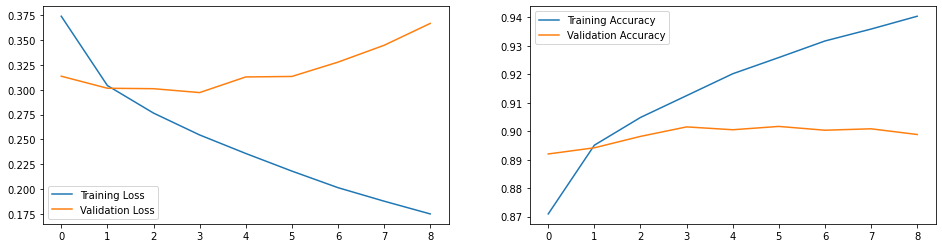

In [ ]:
plot_history(history)

## Confusion Matrix

In [ ]:
pred_test = model.predict(int_test_ds)
pred_test=np.argmax(pred_test, axis=1)

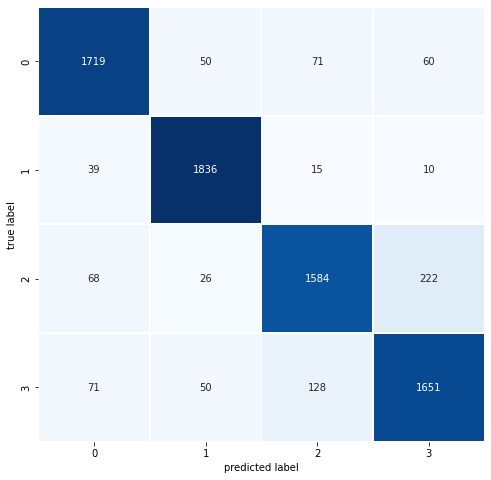

In [ ]:
plot_confusion_matrix(test_ds_labels, pred_test)

## Classification Report

In [ ]:
print_validation_report(test_ds_labels, pred_test)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1900
           1       0.94      0.97      0.95      1900
           2       0.88      0.83      0.86      1900
           3       0.85      0.87      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Accuracy Score: 0.8934210526315789
Root Mean Square Error: 0.5683540408842658


# Experiment 12 - 2 layers (128, 64 nodes) with dense layer

## Prepare Integer Sequence Datasets

In [ ]:
max_length = 60 # words per article used
max_tokens = 4000 # words in vocabulary
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

## Word Embedding with GloVe

In [ ]:
# prepare GloVe word-embeddings matrix
embedding_dim = 200

# Retrieve the vocabulary indexed by our previous TextVectorization layer.
vocabulary = text_vectorization.get_vocabulary()

# Use it to create a mapping from words to their index in the vocabulary.
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Prepare a matrix that we’ll fill with the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Fill entry i in the matrix with the word vector for index i.
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:  # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

## Build & Compile Model

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(embedded) 
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Dense(128, activation='sigmoid')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='sigmoid')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_8 (Embedding)     (None, None, 200)         800000    
                                                                 
 bidirectional_16 (Bidirecti  (None, None, 256)        336896    
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dense_53 (Dense)            (None, 128)               16512     
                                                                 
 dropout_66 (Dropout)        (None, 128)               0  

## Train Model

In [ ]:
%%time
history = model.fit(int_train_ds, 
                    validation_data=int_val_ds, 
                    epochs=200, 
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint("model12.keras", save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) # if val accuracy doesn't improve after 3 epochs, stop training
                        ]
                    )

Epoch 1/200
3563/3563 [==============================] - 116s 28ms/step - loss: 0.4370 - accuracy: 0.8579 - val_loss: 0.3290 - val_accuracy: 0.8957
Epoch 2/200
3563/3563 [==============================] - 92s 26ms/step - loss: 0.3393 - accuracy: 0.8906 - val_loss: 0.3133 - val_accuracy: 0.8963
Epoch 3/200
3563/3563 [==============================] - 92s 26ms/step - loss: 0.3055 - accuracy: 0.9023 - val_loss: 0.3053 - val_accuracy: 0.8992
Epoch 4/200
3563/3563 [==============================] - 91s 26ms/step - loss: 0.2775 - accuracy: 0.9115 - val_loss: 0.3149 - val_accuracy: 0.9022
Epoch 5/200
3563/3563 [==============================] - 91s 26ms/step - loss: 0.2561 - accuracy: 0.9191 - val_loss: 0.3347 - val_accuracy: 0.9055
Epoch 6/200
3563/3563 [==============================] - 91s 25ms/step - loss: 0.2331 - accuracy: 0.9279 - val_loss: 0.3668 - val_accuracy: 0.9018
Epoch 7/200
3563/3563 [==============================] - 91s 25ms/step - loss: 0.2142 - accuracy: 0.9346 - val_loss: 

## Test Model

In [ ]:
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 2s 9ms/step - loss: 0.4184 - accuracy: 0.8996
Test acc: 0.900


## Plot Performance Metrics

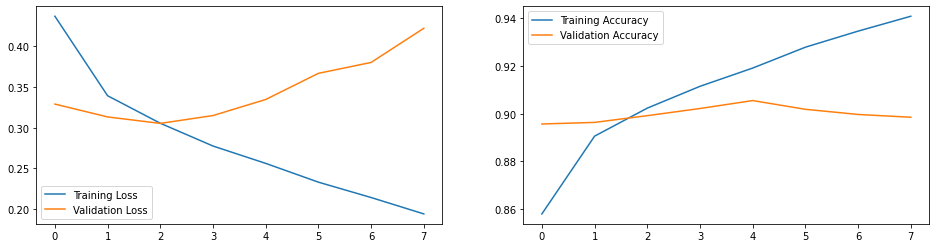

In [ ]:
plot_history(history)

## Confusion Matrix

In [ ]:
pred_test = model.predict(int_test_ds)
pred_test=np.argmax(pred_test, axis=1)

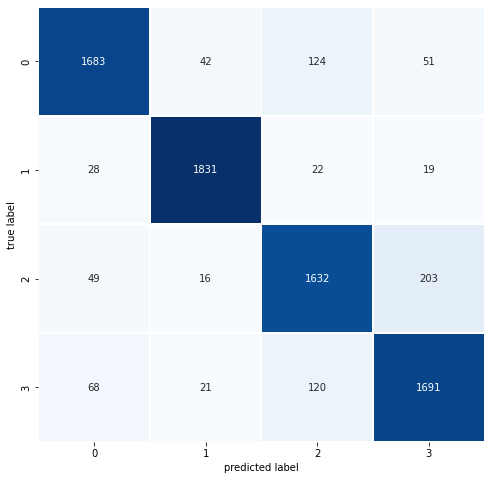

In [ ]:
plot_confusion_matrix(test_ds_labels, pred_test)

## Classification Report

In [ ]:
print_validation_report(test_ds_labels, pred_test)

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1900
           1       0.96      0.96      0.96      1900
           2       0.86      0.86      0.86      1900
           3       0.86      0.89      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600

Accuracy Score: 0.8996052631578947
Root Mean Square Error: 0.5565400633424903


# Experiment 13 - Simple RNN

## Prepare Integer Sequence Datasets

In [ ]:
max_length = 60 # words per article used
max_tokens = 4000 # words in vocabulary
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

## Word Embedding with GloVe

In [ ]:
# prepare GloVe word-embeddings matrix
embedding_dim = 200

# Retrieve the vocabulary indexed by our previous TextVectorization layer.
vocabulary = text_vectorization.get_vocabulary()

# Use it to create a mapping from words to their index in the vocabulary.
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Prepare a matrix that we’ll fill with the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Fill entry i in the matrix with the word vector for index i.
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:  # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

## Build & Compile Model

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.SimpleRNN(128, return_sequences=True)(embedded) 
x = layers.SimpleRNN(64)(x) 
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_5 (Embedding)     (None, None, 200)         800000    
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 128)         42112     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 4)                 260       
                                                                 
Total params: 854,724
Trainable params: 54,724
Non-trainabl

## Train Model

In [ ]:
%%time
history = model.fit(int_train_ds, 
                    validation_data=int_val_ds, 
                    epochs=200, 
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint("model12.keras", save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) # if val accuracy doesn't improve after 3 epochs, stop training
                        ]
                    )

Epoch 1/200
3563/3563 [==============================] - 657s 184ms/step - loss: 0.6227 - accuracy: 0.7940 - val_loss: 0.4999 - val_accuracy: 0.8387
Epoch 2/200
3563/3563 [==============================] - 634s 178ms/step - loss: 0.4973 - accuracy: 0.8376 - val_loss: 0.4182 - val_accuracy: 0.8632
Epoch 3/200
3563/3563 [==============================] - 632s 177ms/step - loss: 0.4839 - accuracy: 0.8423 - val_loss: 0.4705 - val_accuracy: 0.8415
Epoch 4/200
3563/3563 [==============================] - 632s 177ms/step - loss: 0.4782 - accuracy: 0.8444 - val_loss: 0.4386 - val_accuracy: 0.8568
Epoch 5/200
3563/3563 [==============================] - 631s 177ms/step - loss: 0.4640 - accuracy: 0.8493 - val_loss: 0.4318 - val_accuracy: 0.8587
CPU times: user 1h 56min 13s, sys: 20min 15s, total: 2h 16min 29s
Wall time: 54min 21s


## Test Model

In [ ]:
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 4s 17ms/step - loss: 0.4554 - accuracy: 0.8522
Test acc: 0.852


## Plot Performance Metrics

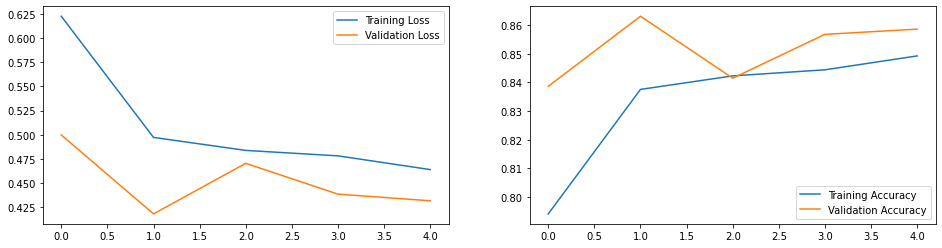

In [ ]:
plot_history(history)

## Confusion Matrix

In [ ]:
pred_test = model.predict(int_test_ds)
pred_test=np.argmax(pred_test, axis=1)

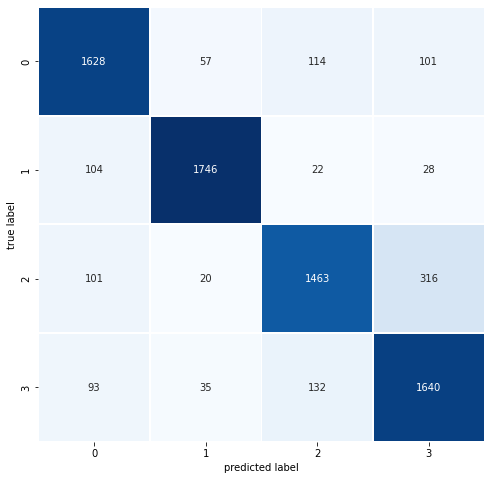

In [ ]:
plot_confusion_matrix(test_ds_labels, pred_test)

## Classification Report

In [ ]:
print_validation_report(test_ds_labels, pred_test)

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1900
           1       0.94      0.92      0.93      1900
           2       0.85      0.77      0.81      1900
           3       0.79      0.86      0.82      1900

    accuracy                           0.85      7600
   macro avg       0.85      0.85      0.85      7600
weighted avg       0.85      0.85      0.85      7600

Accuracy Score: 0.8522368421052632
Root Mean Square Error: 0.6794928449334764


# Experiment 14 - 1D CNN

## Prepare Integer Sequence Datasets

In [ ]:
max_length = 60 # words per article used
max_tokens = 4000 # words in vocabulary
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

## Word Embedding with GloVe

In [ ]:
# prepare GloVe word-embeddings matrix
embedding_dim = 200

# Retrieve the vocabulary indexed by our previous TextVectorization layer.
vocabulary = text_vectorization.get_vocabulary()

# Use it to create a mapping from words to their index in the vocabulary.
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Prepare a matrix that we’ll fill with the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Fill entry i in the matrix with the word vector for index i.
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:  # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

## Build & Compile Model

In [ ]:
inputs = tf.keras.Input(shape=(60,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Conv1D(filters=32, kernel_size=3, activation='sigmoid')(embedded) 
x = layers.MaxPooling1D(pool_size=2)(x) 
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(filters=64, kernel_size=3, activation='sigmoid')(x) 
x = layers.MaxPooling1D(pool_size=2)(x) 
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='sigmoid')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 60)]              0         
                                                                 
 embedding_6 (Embedding)     multiple                  800000    
                                                                 
 conv1d_40 (Conv1D)          (None, 58, 32)            19232     
                                                                 
 max_pooling1d_39 (MaxPoolin  (None, 29, 32)           0         
 g1D)                                                            
                                                                 
 dropout_60 (Dropout)        (None, 29, 32)            0         
                                                                 
 conv1d_41 (Conv1D)          (None, 27, 64)            6208      
                                                          

## Train Model

In [ ]:
%%time
history = model.fit(int_train_ds, 
                    validation_data=int_val_ds, 
                    epochs=200, 
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint("model12.keras", save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) # if val accuracy doesn't improve after 3 epochs, stop training
                        ]
                    )

Epoch 1/200
3563/3563 [==============================] - 21s 6ms/step - loss: 0.7405 - accuracy: 0.6811 - val_loss: 0.4200 - val_accuracy: 0.8527
Epoch 2/200
3563/3563 [==============================] - 17s 5ms/step - loss: 0.5137 - accuracy: 0.8274 - val_loss: 0.3830 - val_accuracy: 0.8735
Epoch 3/200
3563/3563 [==============================] - 19s 5ms/step - loss: 0.4843 - accuracy: 0.8420 - val_loss: 0.3723 - val_accuracy: 0.8808
Epoch 4/200
3563/3563 [==============================] - 18s 5ms/step - loss: 0.4725 - accuracy: 0.8474 - val_loss: 0.3702 - val_accuracy: 0.8802
Epoch 5/200
3563/3563 [==============================] - 22s 6ms/step - loss: 0.4616 - accuracy: 0.8526 - val_loss: 0.3739 - val_accuracy: 0.8793
Epoch 6/200
3563/3563 [==============================] - 18s 5ms/step - loss: 0.4576 - accuracy: 0.8550 - val_loss: 0.3641 - val_accuracy: 0.8832
Epoch 7/200
3563/3563 [==============================] - 17s 5ms/step - loss: 0.4559 - accuracy: 0.8564 - val_loss: 0.3672 -

## Test Model

In [ ]:
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 1s 3ms/step - loss: 0.3843 - accuracy: 0.8775
Test acc: 0.877


## Plot Performance Metrics

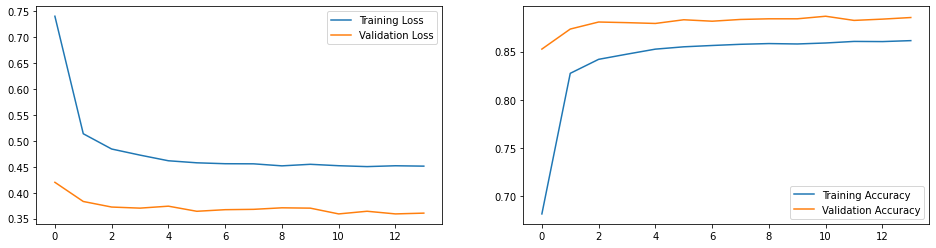

In [ ]:
plot_history(history)

## Confusion Matrix

In [ ]:
pred_test = model.predict(int_test_ds)
pred_test=np.argmax(pred_test, axis=1)

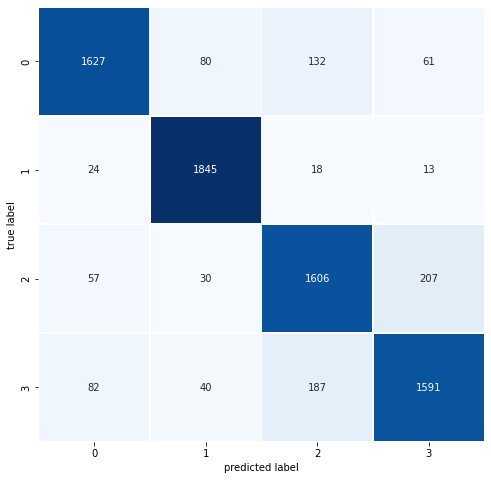

In [ ]:
plot_confusion_matrix(test_ds_labels, pred_test)

## Classification Report

In [ ]:
print_validation_report(test_ds_labels, pred_test)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1900
           1       0.92      0.97      0.95      1900
           2       0.83      0.85      0.84      1900
           3       0.85      0.84      0.84      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

Accuracy Score: 0.8775
Root Mean Square Error: 0.6070853577372356
